In [27]:
import sys
sys.path.append('..')

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import scipy as sp
import pandas as pd
import graph_tool as gt
from tqdm import tqdm
from operator import itemgetter
from functools import reduce
import itertools
import scipy.sparse as sps
from scipy.stats import ks_2samp
import random
import os
#from pymnet import *

import MuxVizPy as mxp

import gseapy as gp

import warnings
warnings.filterwarnings("ignore")


#set.seed(1)

# input data settings
NEIGH_ORDER = 1 # or 0, order of nerighbors, 0 only connected proteins, 1 also first neighbors
CUT_THR = 0.7   # don't change this one

target_folder = "../Data/Virus_data_Enriched_"+str(CUT_THR)+"_Neigh_"+str(NEIGH_ORDER)+"/"

# multilayer settings
layerCouplingStrength = 1
networkOfLayersType = "categorical" ## = all to all

#virus metadata
virus_metadata = pd.read_csv("../Data/Files/viruses_metadata.csv", header=0, sep=";")

virus_metadata_onco = virus_metadata[virus_metadata["isOncogenic"] == True].reset_index()
virus_metadata_nonco = virus_metadata[virus_metadata["isOncogenic"] == False].reset_index()

#dictionary containing a unquie mapping between name of the protein and a corresponding index
node_map_df = pd.read_csv("../Data/Files/node_map.csv")
node_map_dict = {k:(v-1) for k,v in zip(node_map_df["Prot"], node_map_df["Index"])}

In [4]:
def plot_distributions(data, names, xlim, xlabel):
    
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    
    g = np.concatenate([[names[i]]*len(data[i]) for i in range(len(data))])

    data_dict=dict(zip(names,data))
    x = np.concatenate(data)
    df = pd.DataFrame(dict(CompDim=x, g=g))

    g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette="plasma")
    g.map(sns.kdeplot, "CompDim",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
        ax.text(0.8, .2, "%.2f±%.2f"%(np.median(data_dict[label]), np.std(data_dict[label])), color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "CompDim")
    g.figure.subplots_adjust(hspace=-.5)
    g.set_titles("")
    g.set(yticks=[], ylabel="", xlabel=xlabel,xlim=xlim)
    g.despine(bottom=True, left=True)
    
    plt.show()



In [18]:
def plot_boxplots(data, names, xlabel, xlim):
    plt.figure(figsize=(5,9))
    for i in range(len(names)):
        sns.boxplot(data = {"lab": np.concatenate([[i]*len(data[i]) for i in range(len(data))]), "med":np.concatenate(data)}, 
                      y = "lab",
                      x = "med", 
                      palette="plasma", orient="horizontal")
    plt.yticks(np.arange(len(names)), labels=names)
    plt.xlabel(xlabel)
    plt.xlim(xlim)
    plt.grid(ls="--", axis="y")
    plt.tight_layout()

In [41]:
def conf_mat(data, names, ref_dim=None, n_reps=None, title=None):
    
    if ref_dim is None and n_reps is None:
        M_perc = np.zeros([len(data), len(data)])
        for i in range(len(data)):
            for j in range(len(data)):
                M_perc[i,j] = ks_2samp(data[i],data[j]).pvalue
    else:
        mat_list=[]
        for rep in range(n_reps):
            data_list= [np.random.choice(nn, ref_dim, replace=False) for nn in data]
            M_perc = np.zeros([len(data), len(data)])

            for i in range(len(data_list)):
                for j in range(len(data_list)):
                    M_perc[i,j] = ks_2samp(data_list[i],data_list[j]).pvalue
            mat_list.append(M_perc)
        M_perc = np.mean(mat_list, axis=0)
        
        
    #plot
    _, ax = plt.subplots(1,1,figsize=(6,5))
    sns.heatmap(M_perc, annot=True, xticklabels=names, yticklabels=names, ax=ax, fmt=".0e", annot_kws={"size":9})
    if not title is None:
        ax.set_title(title, fontweight="bold")
    ax.set_xticklabels(names, rotation=90)
    plt.show()

# Components

In [2]:
#components size

o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/o_lcc.txt")
o_lic = np.loadtxt("../Data/ComponentsNew/LIC/o_lic.txt")
o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/o_lvc.txt")

n_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n_lcc.txt")
n_lic = np.loadtxt("../Data/ComponentsNew/LIC/n_lic.txt")
n_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n_lvc.txt")

n1o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n1o_lcc.txt")
n1o_lic = np.loadtxt("../Data/ComponentsNew/LIC/n1o_lic.txt")
n1o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n1o_lvc.txt")

n2o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n2o_lcc.txt")
n2o_lic = np.loadtxt("../Data/ComponentsNew/LIC/n2o_lic.txt")
n2o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n2o_lvc.txt")

n3o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n3o_lcc.txt")
n3o_lic = np.loadtxt("../Data/ComponentsNew/LIC/n3o_lic.txt")
n3o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n3o_lvc.txt")

n1o1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n1o1s_lcc.txt")
n1o1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/n1o1s_lic.txt")
n1o1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n1o1s_lvc.txt")

n2o1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n2o1s_lcc.txt")
n2o1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/n2o1s_lic.txt")
n2o1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n2o1s_lvc.txt")

n1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n1s_lcc.txt")
n1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/n1s_lic.txt")
n1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n1s_lvc.txt")

o1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/o1s_lcc.txt")
o1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/o1s_lic.txt")
o1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/o1s_lvc.txt")

In [ ]:
# LIC and LVC composition

o_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/o.txt")
o_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/o.txt")

n_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n.txt")
n_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n.txt")

n1o_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n1o.txt")
n1o_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n1o.txt")

n2o_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n2o.txt")
n2o_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n2o.txt")

n3o_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n3o.txt")
n3o_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n3o.txt")

n1o1s_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n1o1s.txt")
n1o1s_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n1o1s.txt")

n2o1s_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n2o1s.txt")
n2o1s_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n2o1s.txt")

n1s_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n1s.txt")
n1s_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n1s.txt")

o1s_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/o1s.txt")
o1s_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/o1s.txt")

## Plots

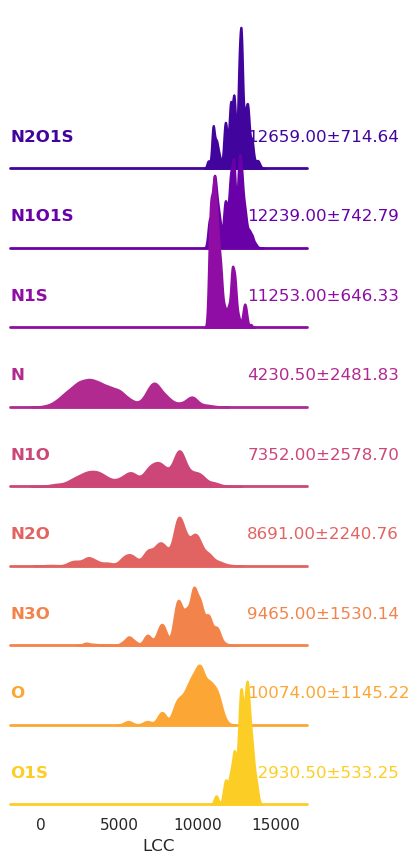

In [11]:
plot_distributions(data = [n2o1s_lcc, n1o1s_lcc, n1s_lcc, n_lcc, n1o_lcc, n2o_lcc, n3o_lcc, o_lcc, o1s_lcc],
                   names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O", "O1S"],
                   xlabel = "LCC",
                   xlim = [-2000,17000])

In [43]:
conf_mat(data = [n2o1s_lcc, n1o1s_lcc, n1s_lcc, n_lcc, n1o_lcc, n2o_lcc, n3o_lcc, o_lcc, o1s_lcc],
         names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O", "O1S"],
         ref_dim=56,
         n_reps=100)

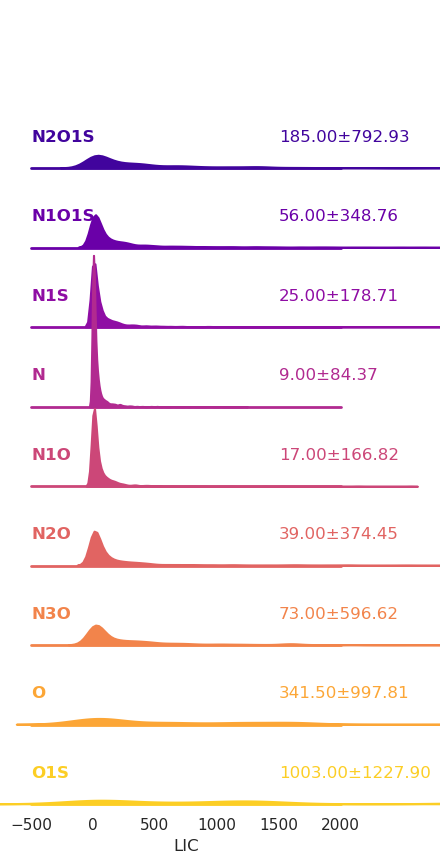

In [9]:
plot_distributions(data = [n2o1s_lic, n1o1s_lic, n1s_lic, n_lic, n1o_lic, n2o_lic, n3o_lic, o_lic, o1s_lic],
                   names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O", "O1S"],
                   xlabel = "LIC",
                   xlim = [-500,2000])

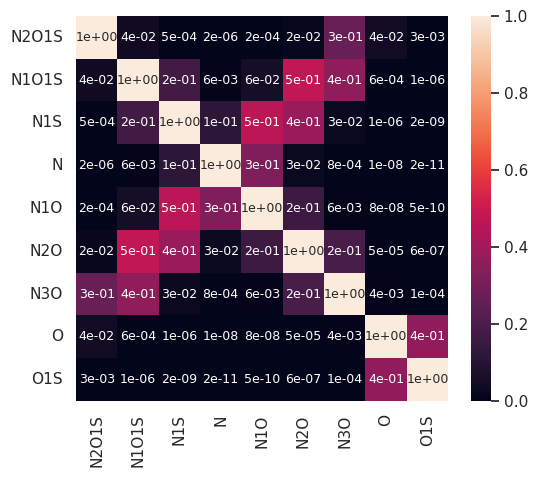

In [44]:
conf_mat(data = [n2o1s_lic, n1o1s_lic, n1s_lic, n_lic, n1o_lic, n2o_lic, n3o_lic, o_lic, o1s_lic],
         names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O", "O1S"],
         ref_dim=56,
         n_reps=100)

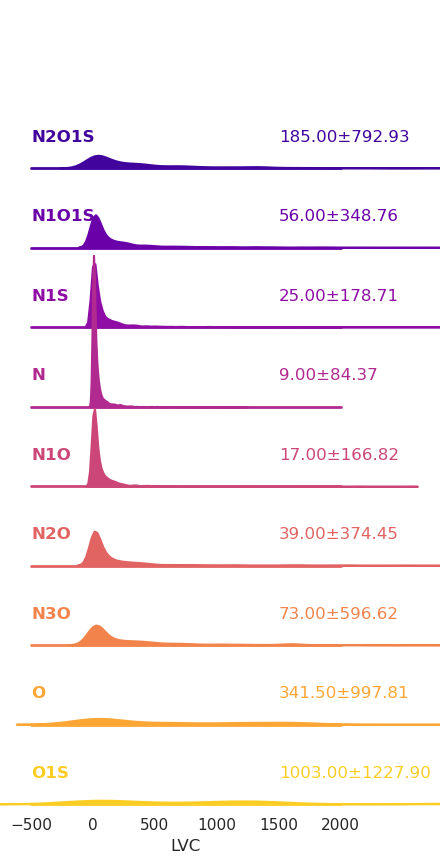

In [10]:
plot_distributions(data = [n2o1s_lvc, n1o1s_lvc, n1s_lvc, n_lvc, n1o_lvc, n2o_lvc, n3o_lvc, o_lvc, o1s_lvc],
                   names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O", "O1S"],
                   xlabel = "LVC",
                   xlim = [-500,2000])

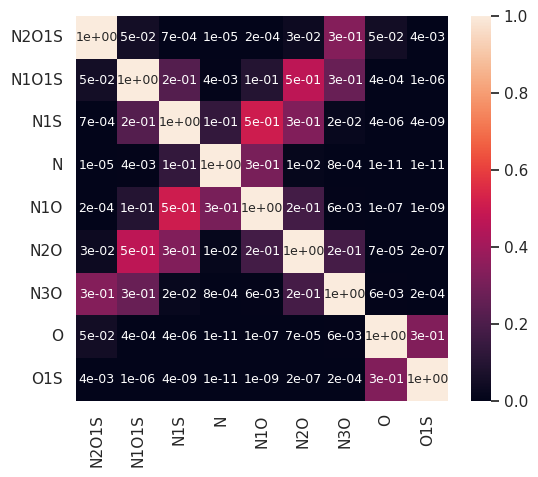

In [45]:
conf_mat(data = [n2o1s_lvc, n1o1s_lvc, n1s_lvc, n_lvc, n1o_lvc, n2o_lvc, n3o_lvc, o_lvc, o1s_lvc],
         names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O", "O1S"],
         ref_dim=56,
         n_reps=100)

## Intersection

In [101]:
def find_itersection(prots, node_map = node_map_dict):
    inter = np.intersect1d(prots[0], prots[1])
    for i in tqdm(range(2, len(prots))):
        inter=np.intersect1d(inter, prots[i])
    if len(inter)!=0:
        return np.array(list(node_map.keys()))[inter]
    else:
        return []

In [103]:
o_lvc_inter = find_itersection(o_lvc_prot)
print((",").join(o_lic_inter.tolist()))

100%|█████████████████████████████████████████| 66/66 [00:00<00:00, 9458.57it/s]

RNF4,DAXX,PARP1,TP53,MDM2,CREBBP,ABL1,HMGA1,HIST2H2BE,PIN1,FBXW7,PML,TRIM25,MAP3K1,MDM4,UBE2I,NKX2-1,SMAD3,TP73,PPM1D,HNRNPL,KIAA1429,SMAD2,CTBP1,CBX4,ACTBL2,RANBP9,SUMO2,SKI,PIAS1


In [54]:
n_lic_inter = find_itersection(o1s_lvc_prot)
n_lic_inter

100%|█████████████████████████████████████████| 63/63 [00:00<00:00, 6981.64it/s]


array(['MDM2', 'TRIM25', 'TP73', 'PPM1D', 'CBX4', 'ACTBL2', 'SUMO2'],
      dtype='<U32')

## Protein frequence

In [ ]:
n_lic_un, n_lic_cnt = np.unique(np.concatenate(n_lic_prot[:2000]), return_counts=True)
n_lvc_un, n_lvc_cnt = np.unique(np.concatenate(n_lvc_prot[:2000]), return_counts=True)

n_lic_freq = pd.DataFrame({"Prot_ind": n_lic_un.astype(int), "Counts": n_lic_cnt}) 
n_lic_freq["Prot_name"] = np.array(list(node_map_dict.keys()))[n_lic_freq["Prot_ind"]]
n_lvc_freq = pd.DataFrame({"Prot_ind": n_lvc_un.astype(int), "Counts": n_lvc_cnt}) 
n_lvc_freq["Prot_name"] = np.array(list(node_map_dict.keys()))[n_lvc_freq["Prot_ind"]]

n_lvc_sorted = n_lvc_freq.sort_values("Counts", ascending=False)[["Prot_name", "Counts"]]
n_lic_dict = dict(zip(n_lic_sorted["Prot_name"], n_lic_sorted["Counts"]))

In [108]:
n_lvc_freq["Counts_LIC"] = n_lvc_freq["Prot_name"].map(n_lic_dict)

In [118]:
top_res = n_lvc_freq.sort_values("Counts_LIC", ascending=False)[["Prot_name", "Counts", "Counts_LIC"]].head(21).reset_index(drop=True)
top_res.columns=["Protein", "Abs Freq LVC", "Abs Freq LIC"]

In [129]:
top_res["Rel Freq LIC %"] = top_res["Abs Freq LIC"]/20
top_res["Rel Freq LVC %"] = top_res["Abs Freq LVC"]/20
top_res["Abs Freq Diff"] = top_res["Abs Freq LIC"]-top_res["Abs Freq LVC"]
top_res["% Freq Diff"] = (top_res["Abs Freq LIC"]-top_res["Abs Freq LVC"])/top_res["Abs Freq LIC"]*100

In [136]:
top_res

Protein  Abs Freq LVC  Abs Freq LIC  Abs Freq Diff  % Freq Diff  \
0       TP53           796           799              3     0.375469   
1       RELA           733           734              1     0.136240   
2        MYC           643           649              6     0.924499   
3        TNF           643           646              3     0.464396   
4      NTRK1           601           612             11     1.797386   
5     TRIM25           570           570              0     0.000000   
6        UBC           502           502              0     0.000000   
7      COPS5           463           464              1     0.215517   
8   HSP90AA1           406           443             37     8.352144   
9     CTNNB1           422           422              0     0.000000   
10     NFKB1           409           409              0     0.000000   
11    RPS27A           400           400              0     0.000000   
12      AKT1           395           395              0     0.000000   
13  KIAA1429           365           365              0     0.000000   
14      CUL1           356           362              6     1.657459   
15       APP           354           356              2     0.561798   
16      KRAS           338           339              1     0.294985   
17     UBA52           329           329              0     0.000000   
18      ESR1           327           328              1     0.304878   
19       JUN           317           317              0     0.000000   
20      CDK9           300           313             13     4.153355   

    Rel Freq LIC  Rel Freq LVC  Rel Freq LIC %  Rel Freq LVC %  
0          39.95         39.80           39.95           39.80  
1          36.70         36.65           36.70           36.65  
2          32.45         32.15           32.45           32.15  
3          32.30         32.15           32.30           32.15  
4          30.60         30.05           30.60           30.05  
5          28.50         28.50           28.50           28.50  
6          25.10         25.10           25.10           25.10  
7          23.20         23.15           23.20           23.15  
8          22.15         20.30           22.15           20.30  
9          21.10         21.10           21.10           21.10  
10         20.45         20.45           20.45           20.45  
11         20.00         20.00           20.00           20.00  
12         19.75         19.75           19.75           19.75  
13         18.25         18.25           18.25           18.25  
14         18.10         17.80           18.10           17.80  
15         17.80         17.70           17.80           17.70  
16         16.95         16.90           16.95           16.90  
17         16.45         16.45           16.45           16.45  
18         16.40         16.35           16.40           16.35  
19         15.85         15.85           15.85           15.85  
20         15.65         15.00           15.65           15.00

# Mod

In [3]:
o_mods = np.loadtxt("../Data/Mod/o_mods.txt")
o_mody = np.loadtxt("../Data/Mod/o_mody.txt")

n_mods = np.loadtxt("../Data/Mod/n_mods.txt")
n_mody = np.loadtxt("../Data/Mod/n_mody.txt")

n1o_mods = np.loadtxt("../Data/Mod/n1o_mods.txt")
n1o_mody = np.loadtxt("../Data/Mod/n1o_mody.txt")

n2o_mods = np.loadtxt("../Data/Mod/n2o_mods.txt")
n2o_mody = np.loadtxt("../Data/Mod/n2o_mody.txt")

n3o_mods = np.loadtxt("../Data/Mod/n3o_mods.txt")
n3o_mody = np.loadtxt("../Data/Mod/n3o_mody.txt")

n1s_mods = np.loadtxt("../Data/Mod/n1s_mods.txt")
n1s_mody = np.loadtxt("../Data/Mod/n1s_mody.txt")

n1o1s_mods = np.loadtxt("../Data/Mod/n1o1s_mods.txt")
n1o1s_mody = np.loadtxt("../Data/Mod/n1o1s_mody.txt")

n2o1s_mods = np.loadtxt("../Data/Mod/n2o1s_mods.txt")
n2o1s_mody = np.loadtxt("../Data/Mod/n2o1s_mody.txt")

o1s_mods = np.loadtxt("../Data/Mod/o1s_mods.txt")
o1s_mody = np.loadtxt("../Data/Mod/o1s_mody.txt")

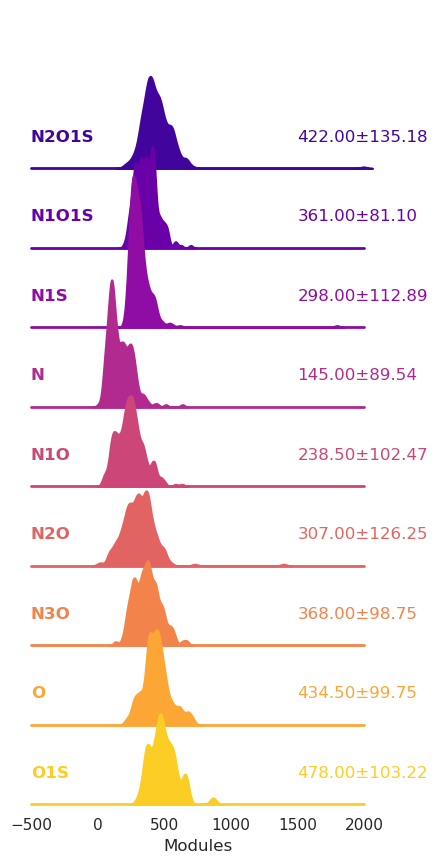

In [6]:
plot_distributions(data = [n2o1s_mods, n1o1s_mods, n1s_mods, n_mods, n1o_mods, n2o_mods, n3o_mods, o_mods, o1s_mods],
                   names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O", "O1S"],
                   xlabel = "Modules",
                   xlim = [-500,2000])

In [46]:
conf_mat(data = [n2o1s_mods, n1o1s_mods, n1s_mods, n_mods, n1o_mods, n2o_mods, n3o_mods, o_mods, o1s_mods],
         names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O", "O1S"],
         ref_dim=56,
         n_reps=100)

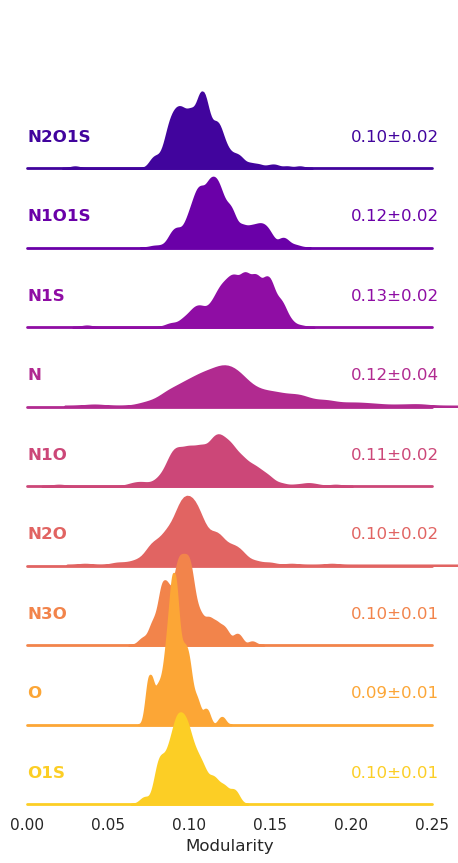

In [7]:
plot_distributions(data = [n2o1s_mody, n1o1s_mody, n1s_mody, n_mody, n1o_mody, n2o_mody, n3o_mody, o_mody, o1s_mody],
                   names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O", "O1S"],
                   xlabel = "Modularity",
                   xlim = [0,0.25])

In [47]:
conf_mat(data = [n2o1s_mody, n1o1s_mody, n1s_mody, n_mody, n1o_mody, n2o_mody, n3o_mody, o_mody, o1s_mody],
         names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O", "O1S"],
         ref_dim=56,
         n_reps=100)

## Correlation

In [ ]:
indd = np.random.choice(np.arange(len(n_mody)),150,replace=False)

In [334]:
mods_fit = np.concatenate([o_mods,o1s_mods,n_mods[indd],n1o_mods[indd],n2o_mods[indd],n3o_mods[indd],n1s_mods[indd],n1o1s_mods[indd],n2o1s_mods[indd]])
lcc_fit = np.concatenate([o_lcc,o1s_lcc,n_lcc[indd],n1o_lcc[indd],n2o_lcc[indd],n3o_lcc[indd],n1s_lcc[indd],n1o1s_lcc[indd],n2o1s_lcc[indd]])
mody_fit = np.concatenate([o_mody,o1s_mody,n_mody[indd],n1o_mody[indd],n2o_mody[indd],n3o_mody[indd],n1s_mody[indd],n1o1s_mody[indd],n2o1s_mody[indd]])

Text(0.5, 1.0, 'MODULARITY')

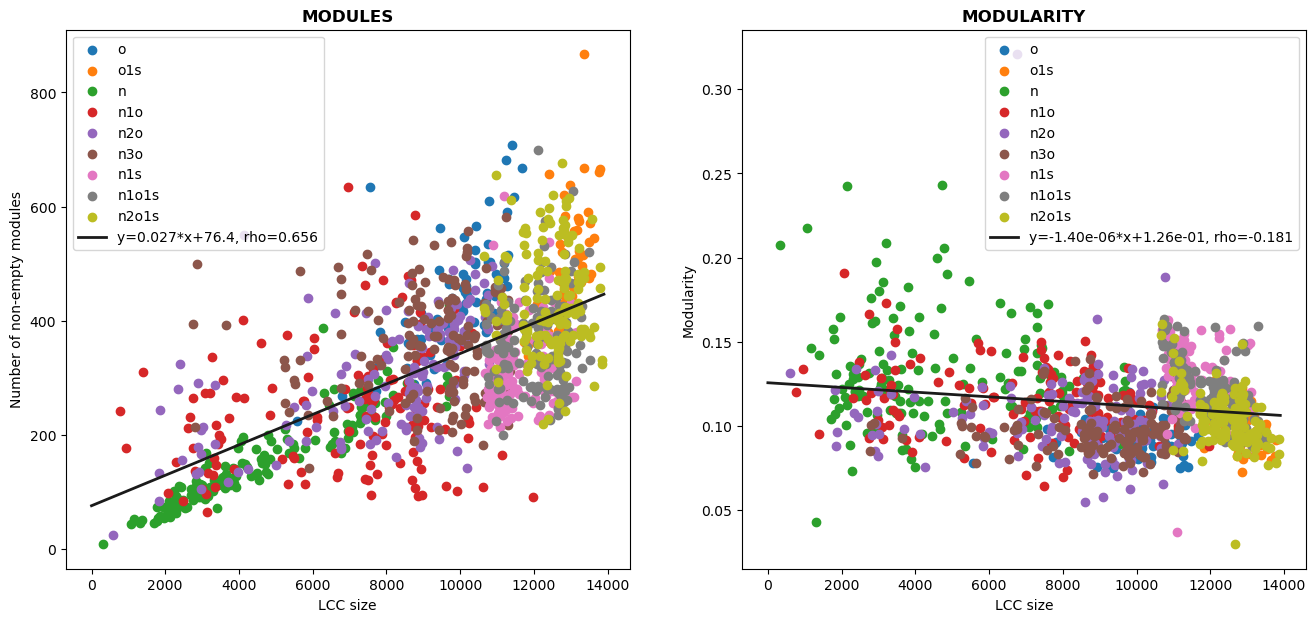

In [362]:
plt.rcdefaults()
_, ax = plt.subplots(1,2, figsize=(16,7))

mods_slope, mods_intercept = np.polyfit(lcc_fit, mods_fit, 1)
mods_coeff = np.corrcoef(lcc_fit, mods_fit)[0,1]
ax[0].scatter(o_lcc, o_mods, label="o")
ax[0].scatter(o1s_lcc, o1s_mods, label="o1s")
ax[0].scatter(n_lcc[indd], n_mods[indd], label="n")
ax[0].scatter(n1o_lcc[indd], n1o_mods[indd], label="n1o")
ax[0].scatter(n2o_lcc[indd], n2o_mods[indd], label="n2o")
ax[0].scatter(n3o_lcc[indd], n3o_mods[indd], label="n3o")
ax[0].scatter(n1s_lcc[indd], n1s_mods[indd], label="n1s")
ax[0].scatter(n1o1s_lcc[indd], n1o1s_mods[indd], label="n1o1s")
ax[0].scatter(n2o1s_lcc[indd], n2o1s_mods[indd], label="n2o1s")
ax[0].plot(np.arange(0,14000,100), np.arange(0,14000,100)*mods_slope+mods_intercept, color="k", lw=2, label="y=%.3f*x+%.1f, rho=%.3f" %(mods_slope, mods_intercept, mods_coeff))
ax[0].legend()
ax[0].set_xlabel("LCC size")
ax[0].set_ylabel("Number of non-empty modules")
ax[0].set_title("MODULES", fontweight="bold")

mody_slope, mody_intercept = np.polyfit(lcc_fit, mody_fit, 1)
mody_coeff = np.corrcoef(lcc_fit, mody_fit)[0,1]
ax[1].scatter(o_lcc, o_mody, label="o")
ax[1].scatter(o1s_lcc, o1s_mody, label="o1s")
ax[1].scatter(n_lcc[indd], n_mody[indd], label="n")
ax[1].scatter(n1o_lcc[indd], n1o_mody[indd], label="n1o")
ax[1].scatter(n2o_lcc[indd], n2o_mody[indd], label="n2o")
ax[1].scatter(n3o_lcc[indd], n3o_mody[indd], label="n3o")
ax[1].scatter(n1s_lcc[indd], n1s_mody[indd], label="n1s")
ax[1].scatter(n1o1s_lcc[indd], n1o1s_mody[indd], label="n1o1s")
ax[1].scatter(n2o1s_lcc[indd], n2o1s_mody[indd], label="n2o1s")
ax[1].plot(np.arange(0,14000,100), np.arange(0,14000,100)*mody_slope+mody_intercept, color="k", lw=2, label="y=%.2e*x+%.2e, rho=%.3f" %(mody_slope, mody_intercept, mody_coeff))
ax[1].legend()
ax[1].set_xlabel("LCC size")
ax[1].set_ylabel("Modularity")
ax[1].set_title("MODULARITY", fontweight="bold")

# Perc

In [13]:
o_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/o.txt")

n_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n.txt")

n1o_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n1o.txt")

n2o_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n2o.txt")

n3o_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n3o.txt")

n1s_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n1s.txt")

n1o1s_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n1o1s.txt")

n2o1s_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/n2o1s.txt")

o1s_perc = 1-np.loadtxt("../Data/ComponentsNew/Perc/o1s.txt")

In [14]:
plot_distributions(data = [n2o1s_perc, n1o1s_perc, n1s_perc, n_perc, n1o_perc, n2o_perc, n3o_perc, o_perc, o1s_perc],
                   names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O", "O1S"],
                   xlabel = "Critical Point",
                   xlim = [0.4,0.9])

In [20]:
plot_boxplots(data = [n2o1s_perc, n1o1s_perc, n1s_perc, n_perc, n1o_perc, n2o_perc, n3o_perc, o_perc, o1s_perc],
              names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O", "O1S"],
              xlabel = "Critical Point",
              xlim = [0.4,0.9])

In [42]:
conf_mat(data = [n2o1s_perc, n1o1s_perc, n1s_perc, n_perc, n1o_perc, n2o_perc, n3o_perc, o_perc, o1s_perc],
         names = ["N2O1S","N1O1S","N1S","N","N1O","N2O","N3O","O", "O1S"],
         ref_dim=56,
         n_reps=100)

# Features separation

In [343]:
o_data = []
for m in [o_lcc,o_lic,o_lvc,o_mods,o_mody,o_perc]:
    o_data.append(m[:70])
o_data =np.array(o_data)
print(o_data.shape)

n_data = []
for m in [n_lcc,n_lic,n_lvc,n_mods,n_mody,n_perc]:
    n_data.append(m[:256])
n_data =np.array(n_data)
print(n_data.shape)

n1s_data = []
for m in [n1s_lcc,n1s_lic,n1s_lvc,n1s_mods,n1s_mody,n1s_perc]:
    n1s_data.append(m[:256])
n1s_data =np.array(n1s_data)
print(n1s_data.shape)

n1o_data = []
for m in [n1o_lcc,n1o_lic,n1o_lvc,n1o_mods,n1o_mody,n1o_perc]:
    n1o_data.append(m[:256])
n1o_data =np.array(n1o_data)
print(n1o_data.shape)

n2o_data = []
for m in [n2o_lcc,n2o_lic,n2o_lvc,n2o_mods,n2o_mody,n2o_perc]:
    n2o_data.append(m[:256])
n2o_data =np.array(n2o_data)
print(n2o_data.shape)

n3o_data = []
for m in [n3o_lcc,n3o_lic,n3o_lvc,n3o_mods,n3o_mody,n3o_perc]:
    n3o_data.append(m[:256])
n3o_data =np.array(n3o_data)
print(n3o_data.shape)

o1s_data = []
for m in [o1s_lcc,o1s_lic,o1s_lvc,o1s_mods,o1s_mody,o1s_perc]:
    o1s_data.append(m[:56])
o1s_data =np.array(o1s_data)
print(o1s_data.shape)

n1o1s_data = []
for m in [n1o1s_lcc,n1o1s_lic,n1o1s_lvc,n1o1s_mods,n1o1s_mody,n1o1s_perc]:
    n1o1s_data.append(m[:256])
n1o1s_data =np.array(n1o1s_data)
print(n1o1s_data.shape)

n2o1s_data = []
for m in [n2o1s_lcc,n2o1s_lic,n2o1s_lvc,n2o1s_mods,n2o1s_mody,n2o1s_perc]:
    n2o1s_data.append(m[:256])
n2o1s_data =np.array(n2o1s_data)
print(n2o1s_data.shape)


(6, 70)
(6, 256)
(6, 256)
(6, 256)
(6, 256)
(6, 256)
(6, 56)
(6, 256)
(6, 256)


In [304]:
comb = list(itertools.combinations(range(6), 3))

for i in range(len(comb)):
    reducer = umap.UMAP(random_state=42)
    data_all = np.concatenate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data],axis=1).T
    embedding = reducer.fit_transform(data_all[:,comb[i]])

    # Generate non-linearly separable data
    X = embedding[:70+256]
    y = np.concatenate([[0]*70,[1]*256])

    # Create an SVM classifier with RBF kernel
    classifier = SVC(kernel='rbf')

    # Train the classifier
    classifier.fit(X, y)
    print(comb[i])
    print(classifier.predict(embedding[0:70]).mean(),classifier.predict(embedding[70:256+70]).mean())

(0, 1, 2)
0.18571428571428572 0.921875
(0, 1, 3)
0.14285714285714285 0.921875
(0, 1, 4)
0.15714285714285714 0.921875
(0, 1, 5)
0.2 0.921875
(0, 2, 3)
0.14285714285714285 0.921875
(0, 2, 4)
0.15714285714285714 0.921875
(0, 2, 5)
0.2 0.921875
(0, 3, 4)
0.12857142857142856 0.91796875
(0, 3, 5)
0.12857142857142856 0.921875
(0, 4, 5)
0.11428571428571428 0.91796875
(1, 2, 3)
0.08571428571428572 0.9609375
(1, 2, 4)
0.9285714285714286 0.99609375
(1, 2, 5)
0.9142857142857143 0.99609375
(1, 3, 4)
0.15714285714285714 0.95703125
(1, 3, 5)
0.2 0.95703125
(1, 4, 5)
1.0 1.0
(2, 3, 4)
0.15714285714285714 0.95703125
(2, 3, 5)
0.2 0.95703125
(2, 4, 5)
1.0 1.0
(3, 4, 5)
0.8142857142857143 0.99609375


In [348]:
comb = list(itertools.combinations(range(6), 4))

for i in range(len(comb)):
    reducer = umap.UMAP(random_state=42)
    data_all = np.concatenate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data, n1o1s_data, n2o1s_data],axis=1).T
    embedding = reducer.fit_transform(data_all[:,comb[i]])

    # Generate non-linearly separable data
    X = embedding[:70+256]
    y = np.concatenate([[0]*70,[1]*256])

    # Create an SVM classifier with RBF kernel
    classifier = SVC(kernel='rbf')

    # Train the classifier
    classifier.fit(X, y)
    print(comb[i])
    print(classifier.predict(embedding[0:70]).mean(),classifier.predict(embedding[70:256+70]).mean())

(0, 1, 2, 3)
0.14285714285714285 0.9140625
(0, 1, 2, 4)
0.14285714285714285 0.921875
(0, 1, 2, 5)
0.11428571428571428 0.9140625
(0, 1, 3, 4)
0.18571428571428572 0.921875
(0, 1, 3, 5)
0.2 0.921875
(0, 1, 4, 5)
0.14285714285714285 0.921875
(0, 2, 3, 4)
0.18571428571428572 0.921875
(0, 2, 3, 5)
0.2 0.921875
(0, 2, 4, 5)
0.14285714285714285 0.921875
(0, 3, 4, 5)
0.12857142857142856 0.921875
(1, 2, 3, 4)
0.08571428571428572 0.9609375
(1, 2, 3, 5)
0.1 0.9609375
(1, 2, 4, 5)
0.5 0.9375
(1, 3, 4, 5)
0.14285714285714285 0.953125
(2, 3, 4, 5)
0.14285714285714285 0.953125


In [306]:
comb = list(itertools.combinations(range(6), 5))

for i in range(len(comb)):
    reducer = umap.UMAP(random_state=42)
    data_all = np.concatenate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data],axis=1).T
    embedding = reducer.fit_transform(data_all[:,comb[i]])

    # Generate non-linearly separable data
    X = embedding[:70+256]
    y = np.concatenate([[0]*70,[1]*256])

    # Create an SVM classifier with RBF kernel
    classifier = SVC(kernel='rbf')

    # Train the classifier
    classifier.fit(X, y)
    print(comb[i])
    print(classifier.predict(embedding[0:70]).mean(),classifier.predict(embedding[70:256+70]).mean())

(0, 1, 2, 3, 4)
0.12857142857142856 0.9140625
(0, 1, 2, 3, 5)
0.14285714285714285 0.9140625
(0, 1, 2, 4, 5)
0.14285714285714285 0.93359375
(0, 1, 3, 4, 5)
0.17142857142857143 0.921875
(0, 2, 3, 4, 5)
0.17142857142857143 0.921875
(1, 2, 3, 4, 5)
0.08571428571428572 0.9609375


In [378]:
X = data_all[:70+256,2:]
y = np.concatenate([[0]*70,[1]*256])
# Create an SVM classifier with RBF kernel
classifier = SVC(kernel='rbf')

# Train the classifier
classifier.fit(X, y)

SVC()

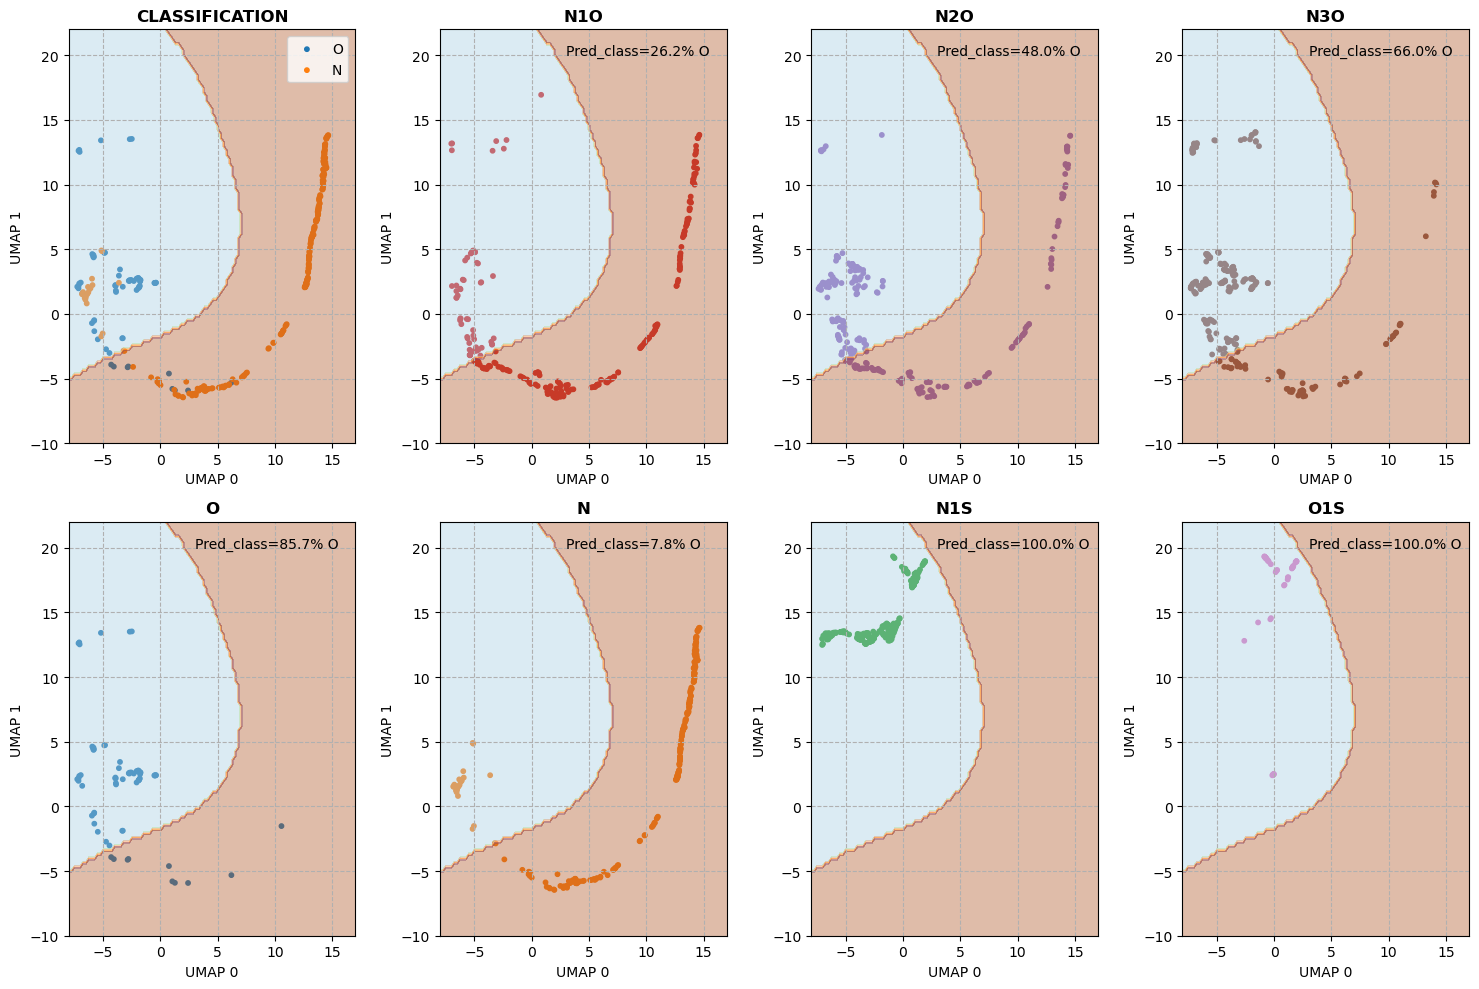

In [364]:
reducer = umap.UMAP(random_state=42)
data_all = np.concatenate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data],axis=1).T
embedding = reducer.fit_transform(data_all[:,[0,1,2,3,4,5]])

# Generate non-linearly separable data
X = embedding[:70+256]
y = np.concatenate([[0]*70,[1]*256])

# Create an SVM classifier with RBF kernel
classifier = SVC(kernel='rbf')

# Train the classifier
classifier.fit(X, y)

# Plot the points and their true labels

# Create a meshgrid to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(-8, 17, 100),
                     np.linspace(-10, 22, 100))

# Predict the labels for the meshgrid points
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted labels to match the meshgrid shape
Z = Z.reshape(xx.shape)

_, ax = plt.subplots(2,4,figsize=(15,10))
ax = ax.flatten()

clist = [[plt.cm.tab10(i)]*len(n.T) for i,n in enumerate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data])]
clist = np.concatenate(clist)

lens = [len(n.T) for n in ([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data])]
limlist = np.concatenate([[0], np.cumsum(lens)])
labels=["O","N","N1S", "N1O", "N2O", "N3O", "O1S", "N1O1S", "N2O1S"]
ax[0].scatter(embedding[limlist[0]:limlist[1],0],embedding[limlist[0]:limlist[1],1], c=clist[limlist[0]:limlist[1]], s=10, label="O")
ax[0].scatter(embedding[limlist[1]:limlist[2],0],embedding[limlist[1]:limlist[2],1], c=clist[limlist[1]:limlist[2]], s=10, label="N")
ax[0].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
ax_list = [4,5,6,1,2,3,7]

for i in range(len(limlist)-1):
    ax[ax_list[i]].scatter(embedding[limlist[i]:limlist[i+1],0],embedding[limlist[i]:limlist[i+1],1], c=clist[limlist[i]:limlist[i+1]], s=10)
    ax[ax_list[i]].set_title(labels[i], fontweight="bold")
    ax[ax_list[i]].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
    ax[ax_list[i]].text(3,20,"Pred_class="+str(np.round((1-classifier.predict(embedding[limlist[i]:limlist[i+1]]).mean())*100,1))+"% O")
[ax[i].set_xlim([-8,17]) for i in range(len(lens)+1)]
[ax[i].set_ylim([-10,22]) for i in range(len(lens)+1)]
[ax[i].set_xlabel("UMAP 0") for i in range(len(lens)+1)]
[ax[i].set_ylabel("UMAP 1") for i in range(len(lens)+1)]
[ax[i].grid(ls="--") for i in range(len(lens)+1)]
ax[0].set_title("CLASSIFICATION", fontweight="bold")
ax[0].legend()
plt.tight_layout()

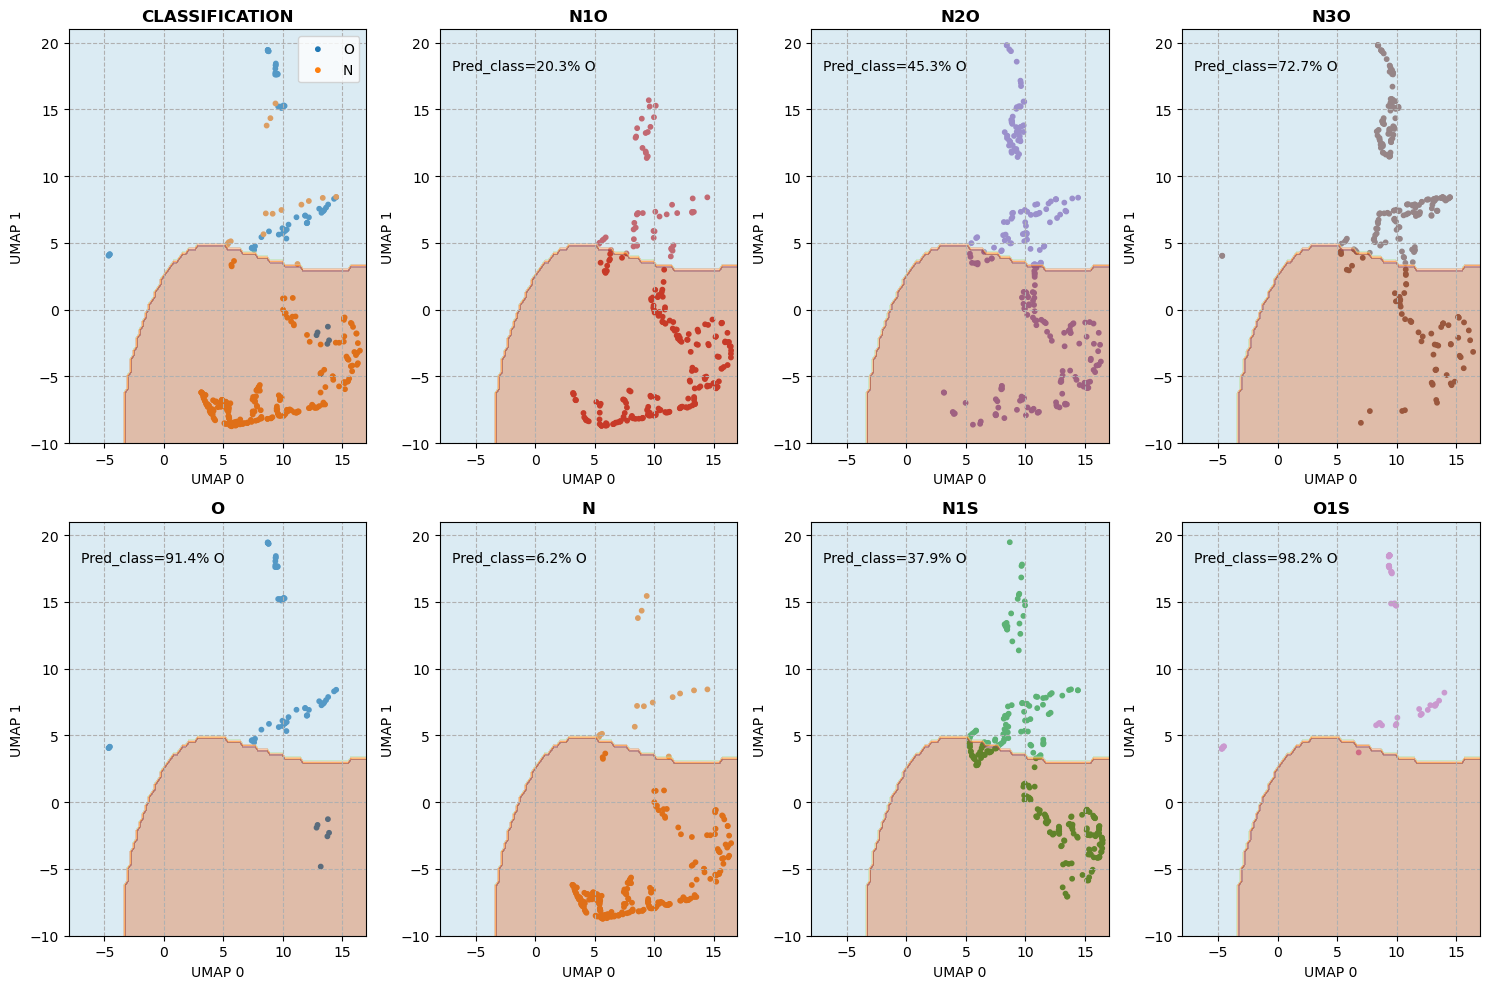

In [362]:
reducer = umap.UMAP(random_state=42)
data_all = np.concatenate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data],axis=1).T
embedding = reducer.fit_transform(data_all[:,[1,3,4,5]])

# Generate non-linearly separable data
X = embedding[:70+256]
y = np.concatenate([[0]*70,[1]*256])

# Create an SVM classifier with RBF kernel
classifier = SVC(kernel='rbf')

# Train the classifier
classifier.fit(X, y)

# Plot the points and their true labels

# Create a meshgrid to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(-8, 17, 100),
                     np.linspace(-10, 21, 100))

# Predict the labels for the meshgrid points
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted labels to match the meshgrid shape
Z = Z.reshape(xx.shape)

_, ax = plt.subplots(2,4,figsize=(15,10))
ax = ax.flatten()

clist = [[plt.cm.tab10(i)]*len(n.T) for i,n in enumerate([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data])]
clist = np.concatenate(clist)

lens = [len(n.T) for n in ([o_data, n_data, n1s_data, n1o_data, n2o_data, n3o_data, o1s_data])]
limlist = np.concatenate([[0], np.cumsum(lens)])
labels=["O","N","N1S", "N1O", "N2O", "N3O", "O1S", "N1O1S", "N2O1S"]
ax[0].scatter(embedding[limlist[0]:limlist[1],0],embedding[limlist[0]:limlist[1],1], c=clist[limlist[0]:limlist[1]], s=10, label="O")
ax[0].scatter(embedding[limlist[1]:limlist[2],0],embedding[limlist[1]:limlist[2],1], c=clist[limlist[1]:limlist[2]], s=10, label="N")
ax[0].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
ax_list = [4,5,6,1,2,3,7]

for i in range(len(limlist)-1):
    ax[ax_list[i]].scatter(embedding[limlist[i]:limlist[i+1],0],embedding[limlist[i]:limlist[i+1],1], c=clist[limlist[i]:limlist[i+1]], s=10)
    ax[ax_list[i]].set_title(labels[i], fontweight="bold")
    ax[ax_list[i]].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
    ax[ax_list[i]].text(-7,18,"Pred_class="+str(np.round((1-classifier.predict(embedding[limlist[i]:limlist[i+1]]).mean())*100,1))+"% O")
[ax[i].set_xlim([-8,17]) for i in range(len(lens)+1)]
[ax[i].set_ylim([-10,21]) for i in range(len(lens)+1)]
[ax[i].set_xlabel("UMAP 0") for i in range(len(lens)+1)]
[ax[i].set_ylabel("UMAP 1") for i in range(len(lens)+1)]
[ax[i].grid(ls="--") for i in range(len(lens)+1)]
ax[0].set_title("CLASSIFICATION", fontweight="bold")
ax[0].legend()
plt.tight_layout()